In [37]:
import streamlit as st
import torch
import torch.nn as nn                    # For building neural networks
import torch.optim as optim              # For optimization algorithms
import torch.nn.functional as F          # For activation functions and other utilities
from torchvision import datasets, transforms  # For loading and transforming datasets
from torch.utils.data import DataLoader  # For data loading and batching
import matplotlib.pyplot as plt          # For plotting
import numpy as np
from PIL import Image
import cv2



In [38]:
from CNNModelMNIST import CNNModel, show_images      # Import the CNN model class and the show_images function


# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [39]:
# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])

In [40]:
'''# Download and load the training data - I have amended this to be for MNIST rather than Fashion MNIST
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)

# Download and load the test data
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)'''

"# Download and load the training data - I have amended this to be for MNIST rather than Fashion MNIST\ntrain_dataset = datasets.MNIST(\n    root='./data', train=True, download=True, transform=transform)\n\n# Download and load the test data\ntest_dataset = datasets.MNIST(\n    root='./data', train=False, download=True, transform=transform)"

In [41]:
# Define data loaders for batching and shuffling
batch_size = 128

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the classes in the MNIST dataset
classes = [
    'Zero','One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine'
]


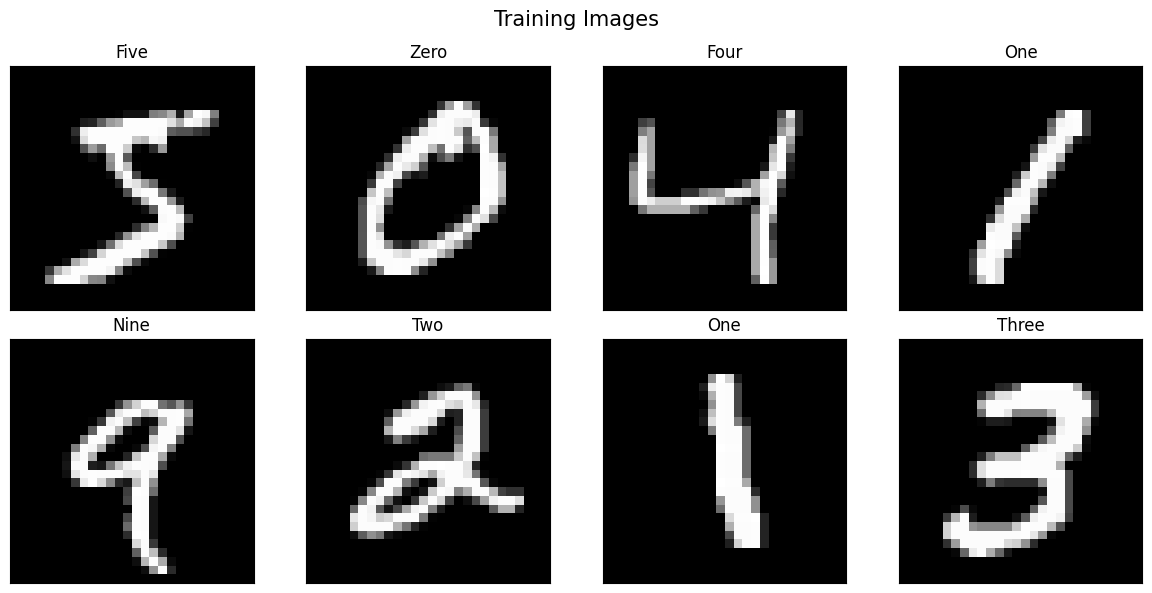

In [42]:
# Display images from the training dataset
show_images(train_dataset, num_images=8, title='Training Images')

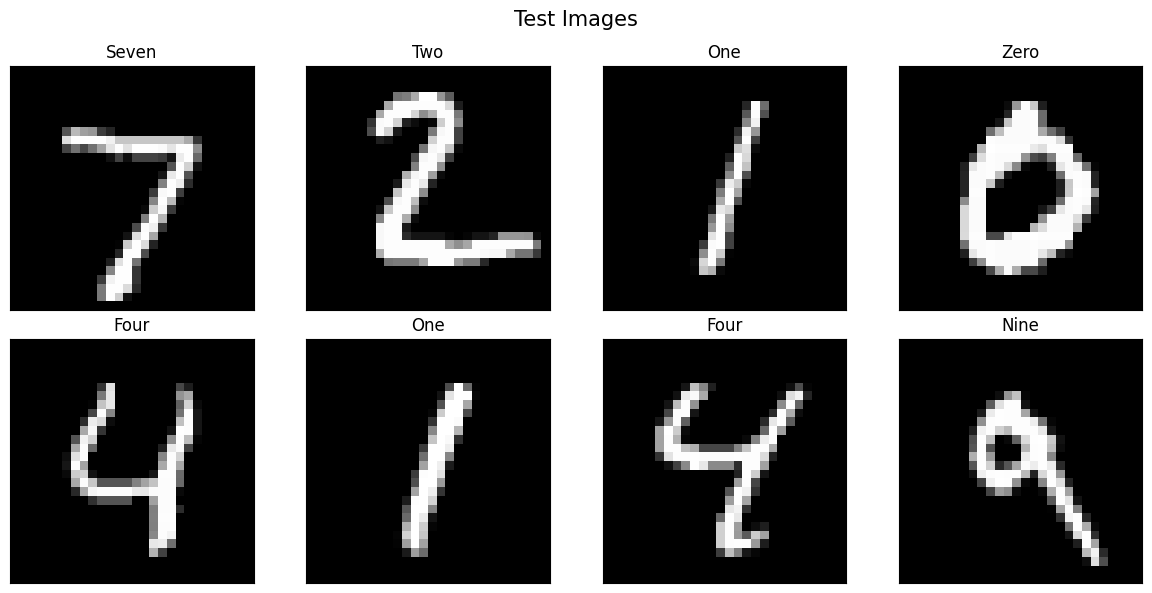

In [43]:
# Display images from the test dataset
show_images(test_dataset, num_images=8, title='Test Images')

In [44]:
# Load the trained model
@st.cache_resource
def load_model():
    model = CNNModel()
    model.load_state_dict(torch.load('mnist_cnn.pth', map_location=torch.device('cpu')))
    model.to(device)
    model.eval()
    print("Model loaded successfully!")
    return model

model = load_model

In [45]:
def preprocess_image(image):
    image = image.convert("L")  # Convert to grayscale
    image = image.resize((28, 28))  # Resize to match MNIST format
    image = np.array(image)  # Convert to numpy array
    image = image.astype(np.float32) / 255.0  # Normalize to [0,1]
    image = (image - 0.5) / 0.5  # Normalize to [-1,1] (same as training)
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 28, 28)
    return image

In [46]:
# Streamlit UI
st.title("Handwritten Digit Recognition")

# Draw input using Streamlit's built-in drawing tool
st.write("Draw a digit below and click 'Predict'")
canvas_result = st.file_uploader("Upload an image of a digit", type=["png", "jpg", "jpeg"])

if canvas_result:
    # Load the image
    image = Image.open(canvas_result)
    st.image(image, caption="Uploaded Image", width=150)

2025-03-18 15:05:44.992 
  command:

    streamlit run c:\Users\nnamd\OneDrive\Python_learning\MLX Project\myenv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [47]:
# Preprocess image
image_tensor = preprocess_image(image)

AttributeError: 'Tensor' object has no attribute 'convert'

In [ ]:
# Run inference
with torch.no_grad():
    output = model(image_tensor)
    probabilities = F.softmax(output, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1).item()
    confidence = torch.max(probabilities).item()

In [ ]:
 # Show results
st.write(f"### Prediction: {predicted_label}")
st.write(f"Confidence: {confidence:.4f}")

In [ ]:
# Allow user to enter correct label for feedback collection
true_label = st.text_input("Enter the correct digit if incorrect:")

if st.button("Submit Feedback"):
    if true_label.isdigit() and 0 <= int(true_label) <= 9:
        st.write(f"Feedback saved! True label was: {true_label}")
    else:
        st.write("Please enter a valid digit (0-9).")

# EXPLORATORY TESTING OF THE CNN MODEL.

In [20]:
# Define indices of images to test
indices = [0, 15, 12, 8]  # These are the indices of the images we want to test

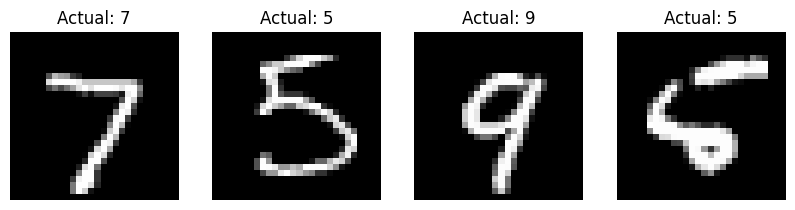

In [21]:
# Extract multiple images and labels
images = torch.stack([test_dataset[i][0] for i in indices])  # Stack images into a batch
labels = [test_dataset[i][1] for i in indices]  # Get corresponding labels

# Display the images
fig, axes = plt.subplots(1, len(indices), figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Actual: {labels[i]}")
    ax.axis('off')
plt.show()

In [28]:
# Prepare images for model (add batch dimension)
images = images.to('cpu')  # Ensure they are on the same device as the model

# Run inference
model.eval()
with torch.no_grad():
    outputs = model(images)  # Forward pass on the batch
    probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
    predicted_labels = torch.argmax(probabilities, dim=1).tolist()  # Get the highest confidence label
    confidence = torch.max(probabilities, dim=1).values.tolist() # Confidence score of the top prediction

    #predicted_labels = torch.argmax(outputs, dim=1).tolist()  # Get predicted labels

# Print actual vs predicted labels
for i, idx in enumerate(indices):
    print(f"Image {idx}: Actual = {labels[i]}, Predicted = {predicted_labels[i]}, Confidence (%)={confidence[i] *100:.2f}")

Image 0: Actual = 7, Predicted = 7, Confidence (%)=100.00
Image 15: Actual = 5, Predicted = 5, Confidence (%)=100.00
Image 12: Actual = 9, Predicted = 9, Confidence (%)=100.00
Image 8: Actual = 5, Predicted = 5, Confidence (%)=98.98
